In [15]:
from brian2 import *
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns

# Dendritic Spines


### notes on the cable equation

Brian is really trying to find the solution to this equation at each compartment

\begin{equation}
\frac{r_m}{r_l}  \frac{\partial^2 V}{\partial x^2} = c_m r_m \frac{\partial V}{\partial t} + V
\end{equation}

or rewritten,

\begin{equation}
\lambda^2  \frac{\partial^2 V}{\partial x^2} = \tau \frac{\partial V}{\partial t} + V
\end{equation}

where $\lambda$ is the space constant and $\tau$ is the time constant.

### on $R_i$
Remember that $R_T$ (R total) defined by Yuste is not the internal resistivity R_i which Brian takes as a parameter.
\begin{equation}
R_T [\Omega] = R_i \frac{L}{\pi a^2}
\end{equation} 

Therefore to get $R_i [\omega \text{cm}]$, we need to know the dimensions of the spine.

\begin{equation}
R_i = R_T \frac{\pi a^2}{L}
\end{equation}

R_i is typically on the order of 100 $[\Omega \text{cm}]$. For the measured value in Cornejo, 100 $M\Omega$, and assuming spine dimensions are on the order $~10^-4 cm (0.1 um)$ for the radius and the length, this gives us an $R_i ~ 10^4$ ohm cm which is two orders of magnitude higher than expected.

## Simulation Code

In [7]:
def default_params(**kwargs):
    p = {
    # morph
    'd_sh' : 1.*um, #um
    'l_sn' : 0.66 *um, # um
    'd_sn' : 0.2 *um, # um
    'd_soma' : 20 *um , # um
    'd_dend': 3 *um, # um
    'l_dend' : 300 *um, # um
    'n_sn' : 5,
    'n_dend' : 10,
    
    # sim
    'VK' : -70. * mV,
    'V_r' : -70. * mV, 
    'gl' : 0.3*msiemens/cm**2,
    'g_AMPA' : 2.08 * nsiemens/cm**2,
    'g_NMDA' : 2.08 * nsiemens/cm**2,
    'gK' : 1*siemens/meter**2,  
    'El' : -70*mV,
    'E_AMPA' : 0 *mV,
    'E_NMDA' : 0 *mV,
    'Cm' :1*uF/cm**2, # specific membrane capacitance
    'Ri': 100*ohm*cm, # intracellular resistivity
    'Ri_sn' : 1e4*ohm*cm,
    'thres' : 'v > 0*mV',
    'ref' : 'v > -10*mV',
    'I_stim' : 10 *pA
    }
    
    p.update(kwargs)
    
    return p

In [8]:
def g12(a1, a2, r1, r2, L1, L2):
    """the conductance between compartments 2->1 (directional)

    Args:
        a1 (float): radius of compartment 1
        a2 (int/float): radius of compartment 2
        r1 (int/float): intracellular resistivity of compartment 1 [ohm*cm]
        r2 (int/float): intracellular resistivity of compartment 2 [ohm*cm]
        L1 (int/float): length of compartment 1 [m]
        L2 (int/float): length of compartment 2 [m]

    Returns:
        float : g_ij conductance of the flow from compartment j to compartment i
    """    
    num = 2* pi * a1**2 * a2**2
    den = a2**2 * r1 * L1 + a1**2 * r2 * L2
    return num/den

In [12]:
def EPSP(monitor):
    """returns EPSP in mV

    Args:
        monitor (State Monitor): the state monitor for the desired compartment

    Returns:
        float : EPSP
    """
    t = monitor.t/ms
    v = monitor.v/mV
    return np.max(v) - v[np.where(t<10)[0][-1]]

In [9]:
def run_sim(params, custom_eqs = None):
    """Run the simulation according to parameters and eqs

    Args:
        params (dict): A dictionary containing all necessary parameters (UPDATES GLOBALLY)
        custom_eqs (str, optional): Path to a python file containing custom eqs (requires eqs_main, eqs_neck, and eqs_spine). Defaults to None.

    Returns:
        M_spine_head, M_spine_neck, M_soma: Monitors for the compartments recording 'v'
    """    
    start_scope()

    # Set the default time step
    defaultclock.dt = 0.01*ms

    # Update parameters
    # (WARNING) Right now I have them set to update globally even though they should update locally.
    globals().update(params)
    
    # ---------------
    # Model Equations
    # ---------------
    if custom_eqs:
        eqs_main = custom_eqs[0]
        eqs_neck = custom_eqs[1]
        eqs_head = custom_eqs[2]
    else:
        eqs_main = '''
        Im = gl * (El - v) : amp/meter**2
        I_long = gDN * (v_neck - v) : amp (point current)
        gDN : siemens
        v_neck : volt
        '''

        eqs_neck = '''
        Im = gl * (El - v) + gK * (VK - v): amp/meter**2
        I_long = gND * (v_dend - v) + gNH * (v_head - v) : amp (point current)
        gND : siemens
        gNH : siemens
        v_dend : volt
        v_head : volt
        '''

        eqs_head = '''
        Im = gl * (El - v) + g_AMPA * (E_AMPA - v) + g_NMDA * B_N * (E_NMDA - v): amp/meter**2
        I_long = gHN * (v_neck - v) : amp (point current)
        g_AMPA : siemens/meter**2
        B_N = 1/(1 + 1/3.57 * exp(-(v/volt)/16.13)) : 1
        gHN : siemens
        v_neck : volt
        '''

    # Create a morphology
    soma_morph = Cylinder(diameter = d_soma, length = d_soma)
    soma_morph.dendrite = Cylinder(diameter = d_dend, length = l_dend, n = n_dend)
    neck_morph = Cylinder(diameter = d_sn, length = l_sn, n = n_sn)
    head_morph = Cylinder(diameter = d_sh, length = d_soma)

    # Generate the neurons
    soma = SpatialNeuron(morphology=soma_morph, model=eqs_main, Cm=Cm, Ri=Ri, threshold = thres, threshold_location=0, refractory = ref)
    neck = SpatialNeuron(morphology=neck_morph, model=eqs_neck, Cm=Cm, Ri=params['Ri_sn'])
    head = SpatialNeuron(morphology=head_morph, model=eqs_head, Cm=Cm, Ri=Ri)

    # Initial System Setup
    head.v = El
    neck.v = El
    soma.v = El
    
    head.g_AMPA = 0    
    neck.gNH = 0
    neck.gND = 0
    soma.gDN = 0
    
    head.gHN = g12(d_sh/2, d_sn/2, Ri, Ri_sn, d_sh, l_sn/2)
    neck[n_sn - 1].gNH = g12(d_sn/2, d_sh/2, Ri_sn, Ri, l_sn/n_sn, d_sh)
    neck[0].gND = g12(d_dend/2, d_sn/2, Ri, Ri_sn, l_dend/n_dend, l_sn/n_sn)
    soma.dendrite[n_dend-1].gDN = g12(d_dend/2, d_sn/2, Ri, Ri_sn, l_dend/n_dend, l_sn/n_sn)
    
    @network_operation
    def f(t):
        head.v_neck = neck[n_sn-1].v
        neck.v_head = head.v
        neck.v_dend = soma.dendrite[n_dend-1].v
        soma.dendrite[n_dend -1].v_neck = neck[0].v

    M_spine_head = StateMonitor(head, ['v'], record=True)
    M_spine_neck = StateMonitor(neck, ['v'], record=True)
    M_soma = StateMonitor(soma, ['v'], record = True)

    # # Starting the simulation

    run(20*ms)
    head.g_AMPA = 10*siemens/meter**2 # send an electric pulse
    run(10*ms)
    head.g_AMPA = 0 * siemens/meter**2
    run(10*ms)

    return M_spine_head, M_spine_neck, M_soma


In [ ]:
def param_comparison(param_str, param_list, plotting = True):
    monitors = []
    if plotting:
        fig, ax = plt.subplots()
    for idx,r in enumerate(param_list):
        M_spine_head, M_spine_neck, M_soma = run_sim(default_params(I_stim = 10*pA, Ri_sn = r*ohm*cm))
        monitors.append(M_soma[0])
        if plotting:
            ax.plot(M_soma)
        
    return 

# Voltage across compartments

Sanity check. Plotted below are the voltages over time for the simulation at 10 ms. The head+neck and soma+dendrite are plotted separately. Note that the dendrite and soma both have 5 compartments.

In [10]:
M_spine_head, M_spine_neck, M_soma = run_sim(default_params())

WARNING    'g_AMPA' is an internal variable of group 'spatialneuron_2', but also exists in the run namespace with the value 2.08e-05 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Text(0, 0.5, '[mV]')

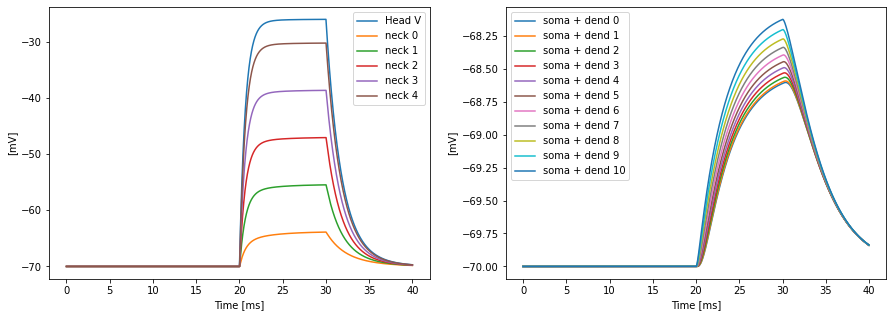

In [11]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
axs[0].plot(M_spine_head.t/ms, M_spine_head.v[0]/mV, label = 'Head V')
for idx, item in enumerate(M_spine_neck):
    axs[0].plot(item.t/ms, item.v/mV, label = 'neck ' + str(idx))
axs[0].legend()
axs[0].set_xlabel('Time [ms]')
axs[0].set_ylabel('[mV]')

for idx, item in enumerate(M_soma):
    axs[1].plot(M_soma.t/ms, item.v/mV, label = 'soma + dend ' + str(idx))
axs[1].legend()
axs[1].set_xlabel('Time [ms]')
axs[1].set_ylabel('[mV]')


### Does NMDA make a difference?
We expect a regime where ecause NMDA conductance is self reinforcing, the NMDA 

### Varying resistance

The length constant $\lambda = \sqrt{\frac{r_m}{r_i}}$ is inversely proportional to $R_i$. The effect on voltage decreases as resistance is increased.

WARNING    'g_AMPA' is an internal variable of group 'spatialneuron_5', but also exists in the run namespace with the value 2.08e-05 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'g_AMPA' is an internal variable of group 'spatialneuron_6', but also exists in the run namespace with the value 2.08e-05 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'g_AMPA' is an internal variable of group 'spatialneuron_7', but also exists in the run namespace with the value 2.08e-05 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'g_AMPA' is an internal variable of group 'spatialneuron_8', but also exists in the run namespace with the value 2.08e-05 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_confli

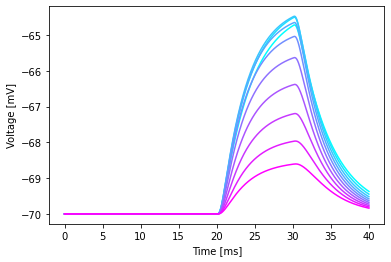

In [13]:
R_VALS = np.logspace(2, 4, 10)
EPSPs_R = np.zeros(len(R_VALS))

ax = plt.axes()
cmap = [matplotlib.cm.get_cmap('cool')(i) for i in np.linspace(0,1,len(R_VALS))]

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Voltage [mV]')

r_time_series = []

for idx,r in enumerate(R_VALS):
    M_spine_head, M_spine_neck, M_soma = run_sim(default_params(I_stim = 10*pA, Ri_sn = r*ohm*cm))
    r_time_series.append(M_soma[0])
    ax.plot(M_soma[0].t/ms, M_soma[0].v/mV, label = "R_neck = " + str(r), color = cmap[idx])
    EPSPs_R[idx] = EPSP(M_soma[0])

Text(0, 0.5, 'EPSP amplitude [mV]')

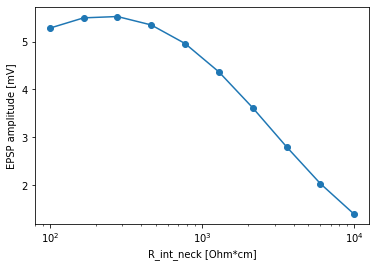

In [14]:
plt.semilogx(R_VALS, EPSPs_R)
plt.scatter(R_VALS, EPSPs_R)
plt.xlabel("R_int_neck [Ohm*cm]")
plt.ylabel("EPSP amplitude [mV]")

### Increasing gk

This should be equivalent to opening up the SK channel. We should see that opening up the SK channel kills whatever signal is being sent to the soma.

WARNING    'g_AMPA' is an internal variable of group 'spatialneuron_15', but also exists in the run namespace with the value 2.08e-05 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'g_AMPA' is an internal variable of group 'spatialneuron_16', but also exists in the run namespace with the value 2.08e-05 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'g_AMPA' is an internal variable of group 'spatialneuron_17', but also exists in the run namespace with the value 2.08e-05 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'g_AMPA' is an internal variable of group 'spatialneuron_18', but also exists in the run namespace with the value 2.08e-05 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_co

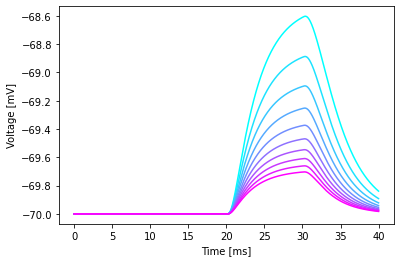

In [16]:
gk_vals = np.linspace(0.01, 1000, 10)
EPSPs = np.zeros(len(gk_vals))

ax = plt.axes()
cmap = [matplotlib.cm.get_cmap('cool')(i) for i in np.linspace(0,1,len(gk_vals))]

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Voltage [mV]')

gk_time_series = []

for idx,gk in enumerate(gk_vals):
    M_spine_head, M_spine_neck, M_soma = run_sim(default_params(gK = gk * msiemens/cm**2))
    ax.plot(M_soma[0].t/ms, M_soma[0].v/mV, label = "gk = " + str(gk), color = cmap[idx])

    gk_time_series.append(M_soma[0])
    EPSPs[idx] = EPSP(M_soma[0])

Text(0, 0.5, 'EPSP amplitude [mV]')

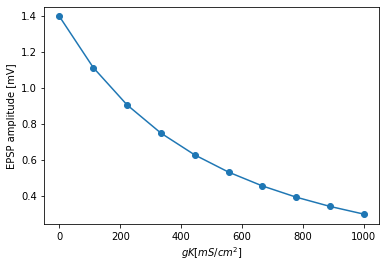

In [11]:

plt.plot(gk_vals, EPSPs)
plt.scatter(gk_vals, EPSPs)
plt.xlabel(r"$gK [mS/cm^{2}]$")
plt.ylabel("EPSP amplitude [mV]")

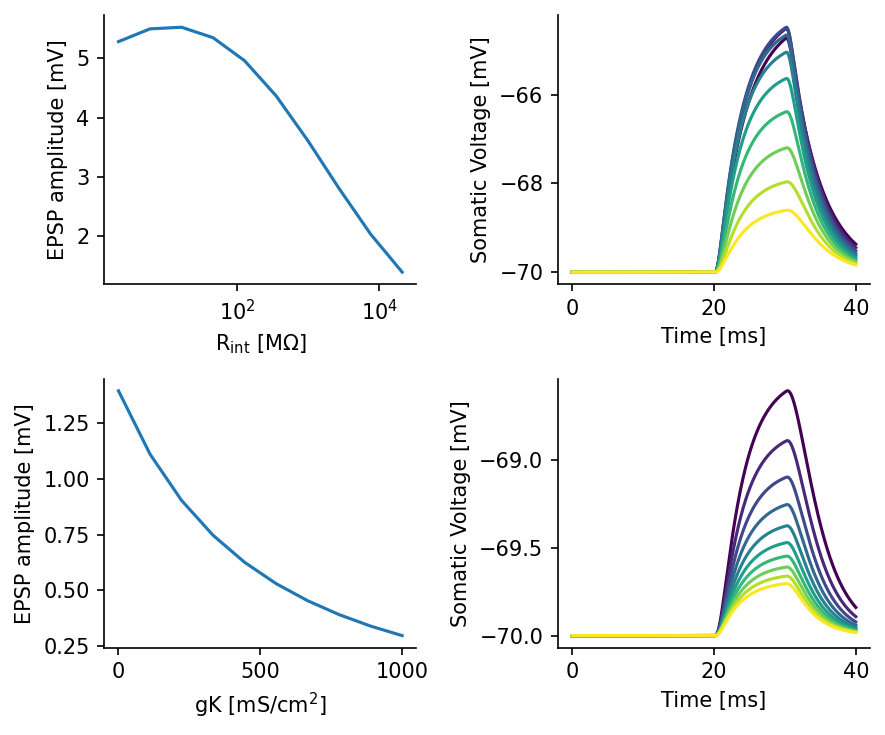

In [55]:
fig, axs = plt.subplots(2,2, figsize=(6,5), dpi = 150, sharex=False)

cmap1 = [matplotlib.cm.get_cmap('viridis')(i) for i in np.linspace(0,1,len(R_VALS))]
cmap2 = [matplotlib.cm.get_cmap('viridis')(i) for i in np.linspace(0,1,len(gk_vals))]

length = default_params()['l_sn']
cross_area = np.pi*(default_params()['d_sn']/2)**2

for ax_h in axs:
    for ax in ax_h:
        # Hide the right and top spines
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

axs[0][0].semilogx(R_VALS*ohm*cm*length/cross_area/Mohm, EPSPs_R)
axs[0][0].set_xlabel(r"R$_\mathrm{int}$ [M$\Omega$]")
axs[0][0].set_ylabel("EPSP amplitude [mV]")

axs[0][1].set_xlabel('Time [ms]')
axs[0][1].set_ylabel('Somatic Voltage [mV]')
for idx, r_mon in enumerate(r_time_series):
    axs[0][1].plot(r_mon.t/ms, r_mon.v/mV, label = "R = " + str(gk), color = cmap1[idx])
    
axs[1][1].set_xlabel('Time [ms]')
axs[1][1].set_ylabel('Somatic Voltage [mV]')
for idx, g_mon in enumerate(gk_time_series):
    axs[1][1].plot(g_mon.t/ms, g_mon.v/mV, label = "gK = " + str(gk), color = cmap2[idx])

axs[1][0].plot(gk_vals, EPSPs)
axs[1][0].set_xlabel(r"gK [mS/cm$^{2}]$")
axs[1][0].set_ylabel("EPSP amplitude [mV]")


fig.tight_layout()
plt.savefig('fig2.png')

### Increasing Spine Neck Length

Amplitude should be inverslely related to neck length

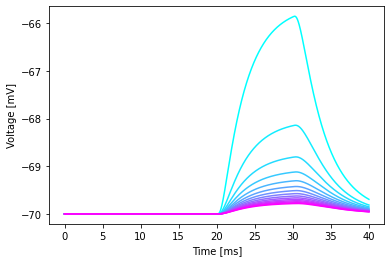

In [64]:
lnecks = np.linspace(0.1, 5, 15)
EPSPs = np.zeros(len(lnecks))

ax = plt.axes()
cmap = [matplotlib.cm.get_cmap('cool')(i) for i in np.linspace(0,1,len(lnecks))]

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Voltage [mV]')

for idx,lneck in enumerate(lnecks):
    M_spine_head, M_spine_neck, M_soma = run_sim(default_params(l_sn = lneck*um))
    ax.plot(M_soma[0].t/ms, M_soma[0].v/mV, label = "length = " + str(lneck), color = cmap[idx])

    EPSPs[idx] = EPSP(M_soma[0])
    


Text(0, 0.5, 'EPSP amplitude [mV]')

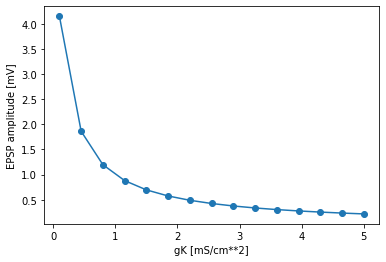

In [65]:
plt.plot(lnecks, EPSPs)
plt.scatter(lnecks, EPSPs)
plt.xlabel("gK [mS/cm**2]")
plt.ylabel("EPSP amplitude [mV]")

In [ ]:
### Shrinking the spine head to be the same as the neck

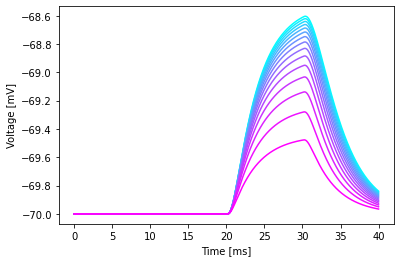

In [69]:
dheads = np.linspace(1, 0.1, 15)
EPSPs = np.zeros(len(lnecks))

ax = plt.axes()
cmap = [matplotlib.cm.get_cmap('cool')(i) for i in np.linspace(0,1,len(dheads))]

ax.set_xlabel('Time [ms]')
ax.set_ylabel('Voltage [mV]')

for idx,dhead in enumerate(dheads):
    M_spine_head, M_spine_neck, M_soma = run_sim(default_params(d_spine_head = dhead*um))
    ax.plot(M_soma[0].t/ms, M_soma[0].v/mV, label = "head dia = " + str(dhead), color = cmap[idx])

    EPSPs[idx] = EPSP(M_soma[0])
    


Text(0, 0.5, 'EPSP amplitude [mV]')

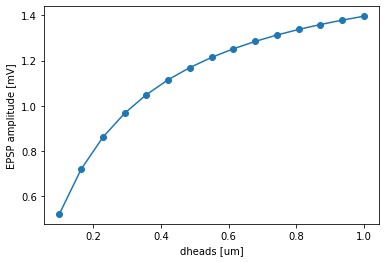

In [73]:
plt.plot(dheads, EPSPs)
plt.scatter(dheads, EPSPs)
plt.xlabel("dheads [um]")
plt.ylabel("EPSP amplitude [mV]")

### Delta EPSP vs Resistance

In [21]:
R_VALS = np.logspace(1, 5, 10)
deltaEPSP_R = np.zeros(len(R_VALS))

for idx,r in enumerate(R_VALS):
    M_spine_head_1, M_spine_neck_1, M_soma_1 = run_sim(default_params(Ri_sn = r*ohm*cm, gK = 0*siemens/meter**2))
    M_spine_head_2, M_spine_neck_2, M_soma_2 = run_sim(default_params(Ri_sn = r*ohm*cm, gK = 1000*siemens/meter**2))
    deltaEPSP_R[idx] = (EPSP(M_soma_1[0]) - EPSP(M_soma_2[0]))/EPSP(M_soma_1[0]) 


WARNING    'g_AMPA' is an internal variable of group 'spatialneuron_12', but also exists in the run namespace with the value 2.08e-05 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'g_AMPA' is an internal variable of group 'spatialneuron_15', but also exists in the run namespace with the value 2.08e-05 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'g_AMPA' is an internal variable of group 'spatialneuron_18', but also exists in the run namespace with the value 2.08e-05 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


NameError: name 'gk' is not defined

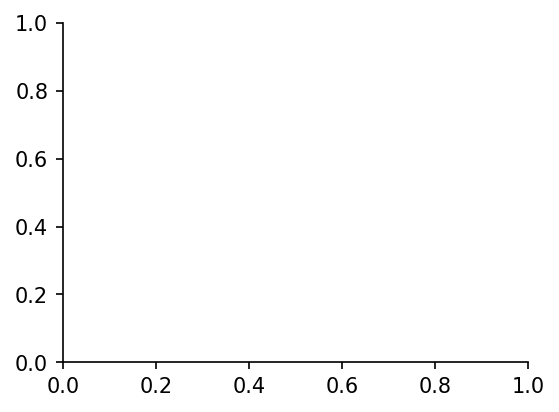

In [24]:
fig, axs = plt.subplots(figsize = (4, 3), dpi = 150)

length = default_params()['l_sn']
cross_area = np.pi*(default_params()['d_sn']/2)**2


# Hide the right and top spines
axs.spines.right.set_visible(False)
axs.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
axs.yaxis.set_ticks_position('left')
axs.xaxis.set_ticks_position('bottom')
    
#axs.scatter(R_VALS, deltaEPSP_R)
axs.plot(R_VALS*ohm*cm*length/cross_area/Mohm, deltaEPSP_R, + str(gk))
axs.set_xscale('log')
axs.set_xlabel(r'R$_\mathrm{int, neck}$ [M$\Omega$]')
axs.set_ylabel(r'$\Delta$ EPSP/EPSP')
fig.tight_layout()
plt.savefig('deltaEPSP.png')
#axs.legend()

Text(0, 0.5, 'deltaEPSP/EPSP')

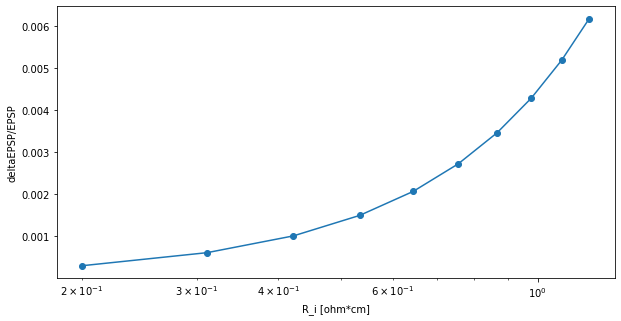

In [75]:
# dneck = 0.2 um
# lneck = 0.66 um

lnecks = np.linspace(0.2, 1.2, 10)
deltaEPSP = np.zeros(len(lnecks))

fig, axs = plt.subplots(figsize = (10, 5))

for idx, lneck in enumerate(lnecks):
    M_spine_head_1, M_spine_neck_1, M_soma_1 = run_sim(default_params(l_sn = lneck*um, gK = 0*siemens/meter**2))
    M_spine_head_2, M_spine_neck_2, M_soma_2 = run_sim(default_params(l_sn = lneck*um, gK = 10*siemens/meter**2))
    deltaEPSP[idx] = (EPSP(M_soma_1[0]) - EPSP(M_soma_2[0]))/EPSP(M_soma_1[0]) 
    
axs.scatter(lnecks, deltaEPSP)
axs.plot(lnecks, deltaEPSP)
axs.set_xscale('log')
axs.set_xlabel('R_i [ohm*cm]')
axs.set_ylabel('deltaEPSP/EPSP')

# Next Steps

Current voltage-dependent K+ channel needs to be changed into a calcium-dependent SK channel (which in turn are inhibited b neuromodulators such as acetylcholine).

Ca2+ iflux from NMDARs and voltage gated calcium channels. (Need to be distinct?)


Much larger voltages in the membrane potential spine head as opposed to the dendrite

Positive feedback - 

AMPA/NMDA ratio actually depends on neck resistance - the higher the neck resistance, the higher the potential deflection in the spine head - the larger the NMDA component.

NMDA conductance is dynamic - voltage dependence - 'How do you get appreciable nmda influx when the conductance is voltage dependent?'

NMDA channel is modeled as
$$
I_{N} = g_{N} r_N(t) B_N(V)(E_N - V) 
$$
where r is the fraction of glutamate-bound receptors (I'm going to assume thie is 1 for now)
and $B_N$ is the coefficient representing NMDAR voltage-dependent Mg2+ unblock.